# Convolutional Neural Network - Cat vs Dog image classification

ORIGINAL DATA SOURCE: https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

The Kaggle Competition: [Cats and Dogs](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) includes 25,000 images of cats and dogs. We will be building a classifier that works with these images and attempt to detect dogs versus cats!

The pictures are numbered 0-12499 for both cats and dogs, thus we have 12,500 images of Dogs and 12,500 images of Cats. This is a huge dataset!!

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

In [1]:
# Importing the Keras libraries and packages
from keras.models import Sequential

# Required for Step 1 - Convolution
from keras.layers import Conv2D

# Required for Step 2 - Pooling 
from keras.layers import MaxPooling2D

# Required for Step 3 - Flattening
from keras.layers import Flatten

# Optional Dropout step
from keras.layers import Dropout

# Required for Step 4 - Full connection ANN - You have already used this
from keras.layers import Dense

In [2]:
import matplotlib.pyplot as plt
import cv2
# Technically not necessary in newest versions of jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Images into Numpy & Visualize them using matplotlib

#### Adjust the path below depending on where you have extracted the CATS_DOGS.zip

In [3]:
cat4 = cv2.imread(r'C:\CIS360\CATS_DOGS\CATS_DOGS\train\CAT\4.jpg')

# cv2 uses BGR as the default color scheme so conver it to RGB which is the default color scheme used by matplotlib
cat4 = cv2.cvtColor(cat4,cv2.COLOR_BGR2RGB)

In [4]:
#cv2.imread loads the image as numpy array
type(cat4)

numpy.ndarray

In [5]:
# These images are color images so will be a 3D np array
cat4.shape

(375, 500, 3)

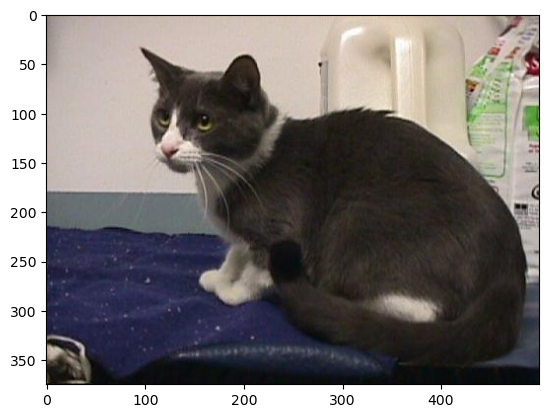

In [6]:
# Show the image using matplotlib
plt.imshow(cat4)

In [8]:
dog10 = cv2.imread(r'C:\CIS360\CATS_DOGS\CATS_DOGS\train\DOG\10.jpg')
dog10 = cv2.cvtColor(dog10,cv2.COLOR_BGR2RGB)
dog10.shape

(293, 269, 3)

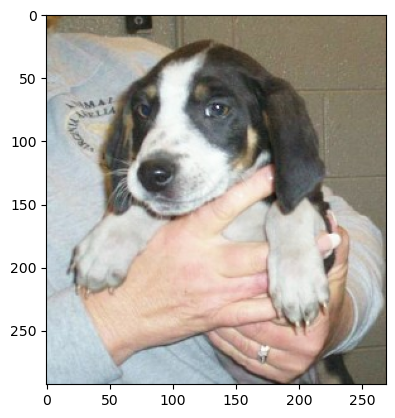

In [9]:
plt.imshow(dog10)

# Part 1 - Building the CNN

## Declare the Model architecture (layers)

Here you are simply defining the model architecture. Not training the model yet

### Step 1 - Convolution

- Add the first layer of CNN - Convolution Layer
- Specify parameters (in order)
    - **filters**: number of filters - One feature map created for each filter you specify
        - Common practice to start with 32 feature detectors in the first Conv layer and then add more (64, 128) feature detectors in subsequent layers
    - **kernel_size**: filter (feature detector) matrix size 3x3 here
    - **input_shape** is 150x150 pixel and 3 since the images are colored rgb
        - So each of the 3 channel corresponds to a 2D array of 150x150. 
        - **We will be resizing images to 150x150 pixel shortly**
        - You can choose higher 2D dim if running on GPU or powerful machine for longer time
        - input_shape will be 150x150x1 for gray scale image
        

In [10]:
# Initialize the CNN
classifier = Sequential()

In [11]:
classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))

### Step 2 - Pooling
- Recommended to start with 2x2 for MaxPooling
- This will reduce the size of feature map (from above layer)

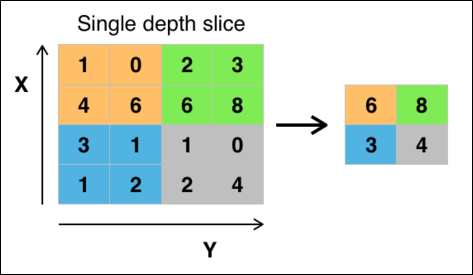

In [12]:
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#### Add a second convolutional layer

In [13]:
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#### Add a third convolutional layer

In [14]:
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

### Step 3 - Flattening

In [15]:
classifier.add(Flatten())

### Step 4 - Full connection
- Use Dense function to create a fully connected layer
- 128 is a number of nodes in the hidden layer (tuning parameter)
- Expecting binary outcome using sigmoid activation function - can use other outcomes and use softmax

In [16]:
classifier.add(Dense(units = 128, activation = 'relu'))

In [17]:
# THIS IS OPTIONAL - YOU CAN REMOVE THIS
# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 30% of neurons.
classifier.add(Dropout(0.3))

In [18]:
# Last layer, remember its binary, 0=cat , 1=dog
classifier.add(Dense(units = 1, activation = 'sigmoid'))

### Compiling the CNN
- Spefify parameters for training the model optimization and measuring the performance
- Using binary_crossentropy since we are treating this a binary outcome problem. Can use categorical outcomes using corresponding entropy functions

In [19]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Let's look at our model architecture

In [20]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

# Preparing the images for training

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!


In [21]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

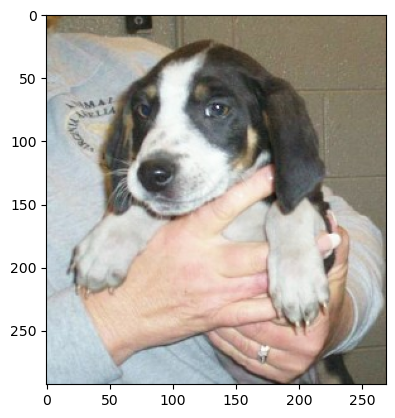

In [24]:
# Let's visualize the original dog10 image
plt.imshow(dog10)

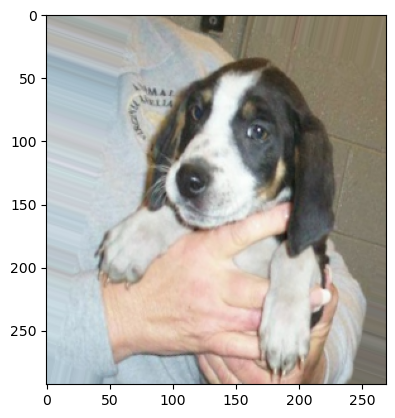

In [25]:
# Let's see how the manipulated dog10 image looks like
plt.imshow(image_gen.random_transform(dog10))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [26]:
image_gen.flow_from_directory(r"C:\CIS360\CATS_DOGS\CATS_DOGS\train")

Found 18743 images belonging to 2 classes.


In [27]:
image_gen.flow_from_directory(r"C:\CIS360\CATS_DOGS\CATS_DOGS\test")

Found 6251 images belonging to 2 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [28]:
# width,height,channels
image_shape = (150,150,3)

# Part 2 - Fitting the CNN to the images

In [30]:
batch_size = 16

train_datagen = image_gen.flow_from_directory(r"C:\CIS360\CATS_DOGS\CATS_DOGS\train",
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [32]:
test_datagen = image_gen.flow_from_directory(r"C:\CIS360\CATS_DOGS\CATS_DOGS\test",
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [33]:
train_datagen.class_indices

{'CAT': 0, 'DOG': 1}

## Train the model - START SMALL - Epochs to 8 then 25, 50, 100 if everything works

Also, start with steps_per_epoch = 150 and then move up 

In [34]:
results = classifier.fit_generator(train_datagen,
                         steps_per_epoch = 150,
                         epochs = 8,
                         validation_data = test_datagen,
                         validation_steps = 1000)

Epoch 1/8
150/150 [==============================] - 81s 539ms/step - loss: 0.6966 - accuracy: 0.5146 - val_loss: 0.6757 - val_accuracy: 0.5983
Epoch 2/8
150/150 [==============================] - 28s 189ms/step - loss: 0.6857 - accuracy: 0.5504
Epoch 3/8
150/150 [==============================] - 27s 183ms/step - loss: 0.6811 - accuracy: 0.5684
Epoch 4/8
150/150 [==============================] - 27s 180ms/step - loss: 0.6760 - accuracy: 0.5758
Epoch 5/8
150/150 [==============================] - 26s 170ms/step - loss: 0.6874 - accuracy: 0.5596
Epoch 6/8
150/150 [==============================] - 25s 165ms/step - loss: 0.6831 - accuracy: 0.5717
Epoch 7/8
150/150 [==============================] - 24s 161ms/step - loss: 0.6710 - accuracy: 0.5746
Epoch 8/8
150/150 [==============================] - 23s 154ms/step - loss: 0.6635 - accuracy: 0.5867


## Evaluate the model - Capture a screen shot of your results and post it on Canvas

In [35]:
results.history['accuracy']

[0.5145833492279053,
 0.5503973364830017,
 0.5683814287185669,
 0.5758333206176758,
 0.559583306312561,
 0.5716666579246521,
 0.5745833516120911,
 0.5866666436195374]

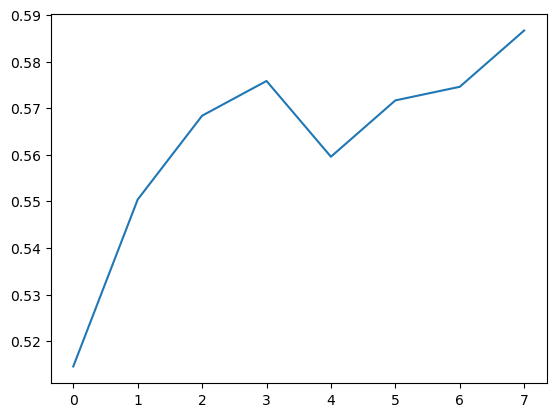

In [36]:
plt.plot(results.history['accuracy'])

# Part 3 - Making new predictions

**Let's understand the indices for the two classes**

In [46]:
train_datagen.class_indices

{'CAT': 0, 'DOG': 1}

In [47]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"C:\CIS360\CATS_DOGS\CATS_DOGS\train\DOG\1.jpg", target_size = (150, 150))

# PIL.Image.Image image mode=RGB size=64x64 
type(test_image)

PIL.Image.Image

In [48]:
## img_to_array converts image from 64x64 to (64, 64, 3) that was used to train the model
test_image = image.img_to_array(test_image)
type(test_image)

numpy.ndarray

In [49]:
## The predict method expects 4 dimension input (3 dim for color image and 4th dim as the batch size)
test_image = np.expand_dims(test_image, axis = 0)

In [52]:
## check dimensions before and after of the numpy array to see 2D, 3D, 4D
result = classifier.predict(test_image)

if result[0][0] == 1:
    print('dog')
else:
    print('cat')

1/1 [==============================] - 0s 17ms/step
cat


In [51]:
classifier.predict(test_image)

1/1 [==============================] - 0s 16ms/step


array([[0.9999081]], dtype=float32)

### Try prediction for the second image

In [53]:
test_image2 = image.load_img(r"C:\CIS360\CATS_DOGS\CATS_DOGS\train\DOG\2.jpg", target_size = (150, 150))

test_image2 = image.img_to_array(test_image2)

## The predict method expects 4 dimension input (3 dim for color image and 4th dim as the batch size)
test_image2 = np.expand_dims(test_image2, axis = 0)

## check dimensions before and after of the numpy array to see 2D, 3D, 4D
result2 = classifier.predict(test_image2)

if result2[0][0] == 1:
    print('dog')
else:
    print('cat')

1/1 [==============================] - 0s 17ms/step
cat


In [54]:
classifier.predict(test_image2)

1/1 [==============================] - 0s 17ms/step


array([[0.00777932]], dtype=float32)

In [55]:
result

array([[0.9999081]], dtype=float32)

# Save Keras Model to a file

- You can save your model by calling the **save()** function on the model and specifying the filename.
- The example below demonstrates this by first fitting a model and saving it to the file model.h5

In [56]:
classifier.save("DogOrCat_Classifier_KerasModel.h5")
print('Model saved to DogOrCat_Classifier_KerasModel.h5')

Model saved to DogOrCat_Classifier_KerasModel.h5
